In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from patsy import dmatrix
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
# 6. In this exercise, you will further analyze the Wage data set considered throughout this chapter.

wage = pd.read_csv('/home/abhishek/Desktop/ISLR-Applied-Exercises-in-Python/data/Wage.csv')
wage.head()
print(wage.shape)


(3000, 12)


In [3]:
wage = wage.iloc[:,1:] # removing irrelevant column
print(wage.shape)
wage.head()

(3000, 11)


,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [4]:
# (a) Perform polynomial regression to predict wage using age. Use cross-validation to select the optimal 
# degree d for the polynomial. What degree was chosen, and how does this compare to the results of hypothesis 
# testing using ANOVA? Make a plot of the resulting polynomial fit to the data.


# a function which performs the polynomial regression, fits and finds a cross validation error for a model with degree 
# from 1 to power
def poly_regression_cv(X, y, power):
    scores_dict = {}
    
    for n in range(1, power+1):
        poly = PolynomialFeatures(n, include_bias=False)
        X_transformed = poly.fit_transform(X.to_frame())
        lin_reg = LinearRegression()
        scores_dict[n] = (-np.mean(cross_val_score(lin_reg, X_transformed, y, scoring = 'neg_mean_squared_error', cv=5)))
    return scores_dict

In [5]:
X = wage['age']
y = wage['wage']

scores_dict = poly_regression_cv(X, y, 15)

Text(0.5, 1.0, 'Polynomial regression using CV')

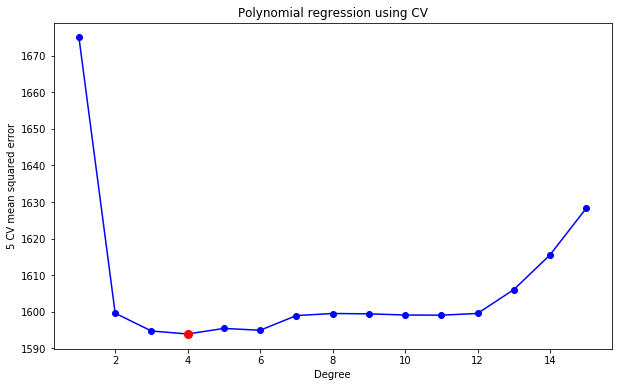

In [6]:
plt.figure(figsize = (10, 6))
plt.plot(np.arange(1, 16), list(scores_dict.values()), marker = 'o', color = 'b')
plt.plot(np.argmin(list(scores_dict.values()))+1, np.min(list(scores_dict.values())), marker = 'o', markersize = 8, color = 'red' )
plt.xlabel('Degree')
plt.ylabel('5 CV mean squared error')
plt.title('Polynomial regression using CV')

In [7]:
# the degree for which the error is minimum is 4.

In [11]:
poly = PolynomialFeatures(5)
X = poly.fit_transform(wage['age'].to_frame())
y = wage['wage']

X_df = pd.DataFrame(X)
X_df.columns = ['Constant'] + ['X_' + str(i) for i in range(1,6)]
X_df.head()

,Constant,X_1,X_2,X_3,X_4,X_5
0,1.0,18.0,324.0,5832.0,104976.0,1889568.0
1,1.0,24.0,576.0,13824.0,331776.0,7962624.0
2,1.0,45.0,2025.0,91125.0,4100625.0,184528125.0
3,1.0,43.0,1849.0,79507.0,3418801.0,147008443.0
4,1.0,50.0,2500.0,125000.0,6250000.0,312500000.0


In [13]:
fit_1 = sm.OLS(y, X_df.iloc[:,:2]).fit() # degree 1
fit_2 = sm.OLS(y, X_df.iloc[:,:3]).fit() # degree 2
fit_3 = sm.OLS(y, X_df.iloc[:,:4]).fit() # degree 3
fit_4 = sm.OLS(y, X_df.iloc[:,:5]).fit() # degree 4
fit_5 = sm.OLS(y, X_df.iloc[:,:6]).fit() # degree 5

table = sm.stats.anova_lm(fit_1, fit_2, fit_3, fit_4, fit_5)
print(table)

   df_resid           ssr  df_diff        ss_diff           F        Pr(>F)
0    2998.0  5.022216e+06      0.0            NaN         NaN           NaN
1    2997.0  4.793430e+06      1.0  228786.010128  143.593107  2.363850e-32
2    2996.0  4.777674e+06      1.0   15755.693664    9.888756  1.679202e-03
3    2995.0  4.771604e+06      1.0    6070.152124    3.809813  5.104620e-02
4    2994.0  4.770322e+06      1.0    1282.563017    0.804976  3.696820e-01


In [14]:
# Annova model chooses degree 3 as the best. 

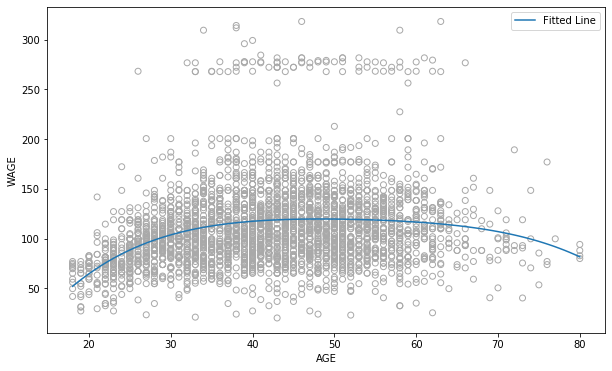

In [21]:
# we would use degree 4 that we got from CV

poly = PolynomialFeatures(4)
X = poly.fit_transform(wage['age'].to_frame())
y = wage['wage']

model = LinearRegression().fit(X, y)

test_ages = np.linspace(wage['age'].min(), wage['age'].max(), 100)
# test_ages
X_test = poly.transform(test_ages.reshape(-1, 1))
pred = model.predict(X_test)

pred = model.predict(X_test)

plt.figure(figsize = (10, 6))
plt.scatter(wage['age'], wage['wage'], facecolors = 'none', edgecolors = 'darkgray')
plt.plot(test_ages, pred, label = 'Fitted Line')
plt.xlabel('AGE')
plt.ylabel('WAGE')
plt.legend()

In [24]:
# (b) Fit a step function to predict wage using age, and perform crossvalidation to choose the optimal number 
# of cuts. Make a plot of the fit obtained

def step_functions_cv(X, y, total_steps):
    scores_dict = {}
    
    for cut in range(2, total_steps):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 0)
        X_cut_train = pd.cut(X_train, cut)
        X_dummies_train = pd.get_dummies(X_cut_train)
        
        X_cut_test = pd.cut(X_test, cut)
        X_dummies_test = pd.get_dummies(X_cut_test)
        
        model = sm.OLS(y_train, X_dummies_train).fit()
        preds = model.predict(X_dummies_test)
        scores_dict[cut] = mean_squared_error(y_test, preds)
    return scores_dict

In [25]:
scores_dict_steps = step_functions_cv(wage['age'], wage['wage'], 16)

Text(0, 0.5, 'Validation Error')

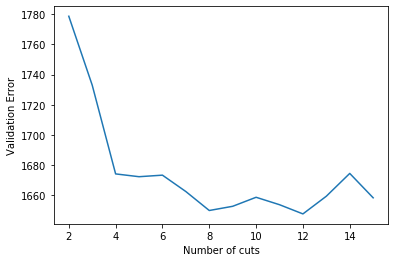

In [26]:
plt.plot(list(scores_dict_steps.keys()), list(scores_dict_steps.values()))
plt.xlabel('Number of cuts')
plt.ylabel('Validation Error')

In [27]:
# we can see from the above graph that the best performance is when cuts = 8

In [28]:
# the selected step function

X_cut = pd.cut(wage['age'], 8)
X_dummies = pd.get_dummies(X_cut)

model = sm.OLS(wage['wage'], X_dummies).fit()
preds = model.predict(X_dummies)


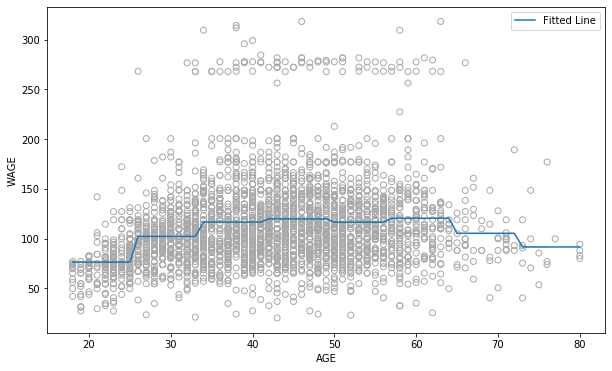

In [29]:
plt.figure(figsize = (10,6))
plt.scatter(wage['age'],wage['wage'],facecolors='none', edgecolors='darkgray')
sns.lineplot(wage['age'],preds,label = 'Fitted Line')
plt.xlabel('AGE')
plt.ylabel('WAGE')
plt.legend()

In [30]:
# 7. The Wage data set contains a number of other features not explored in this chapter, such as marital 
# status (maritl), job class (jobclass), and others. Explore the relationships between some of these other 
# predictors and wage, and use non-linear fitting techniques in order to fit flexible models to the data. 
# Create plots of the results obtained, and write a summary of your findings.


wage.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [31]:
wage.dtypes

year            int64
age             int64
maritl         object
race           object
education      object
region         object
jobclass       object
health         object
health_ins     object
logwage       float64
wage          float64
dtype: object

In [32]:
qual_variables = [col for col in wage.columns if wage[col].dtypes == 'O']

for col in qual_variables:
    print(col, wage[col].unique())

maritl ['1. Never Married' '2. Married' '4. Divorced' '3. Widowed' '5. Separated']
race ['1. White' '3. Asian' '4. Other' '2. Black']
education ['1. < HS Grad' '4. College Grad' '3. Some College' '2. HS Grad'
 '5. Advanced Degree']
region ['2. Middle Atlantic']
jobclass ['1. Industrial' '2. Information']
health ['1. <=Good' '2. >=Very Good']
health_ins ['2. No' '1. Yes']


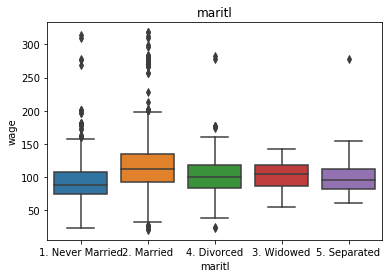

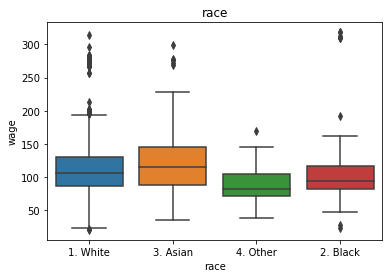

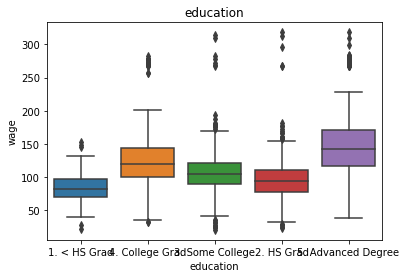

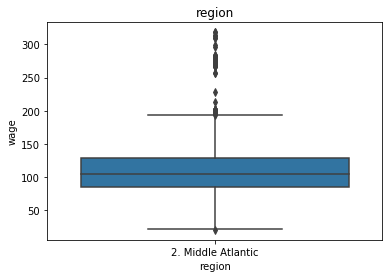

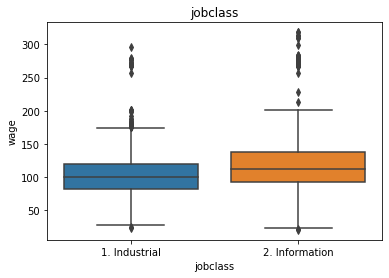

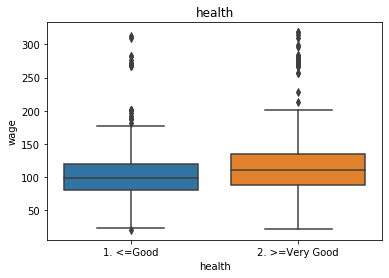

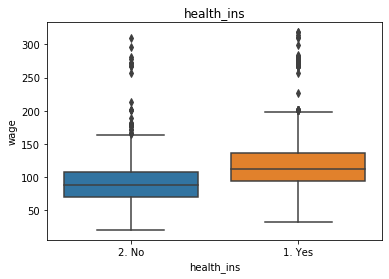

In [34]:
for col in qual_variables:
    if not col == 'wage':
        sns.boxplot(x = col, y = 'wage', data = wage)
        plt.title(col)
        plt.show()

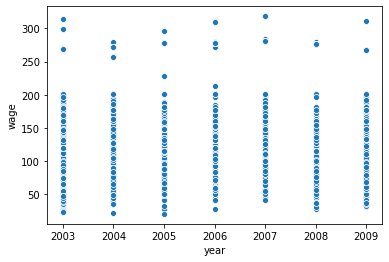

In [35]:
sns.scatterplot(x = 'year', y = 'wage', data = wage)

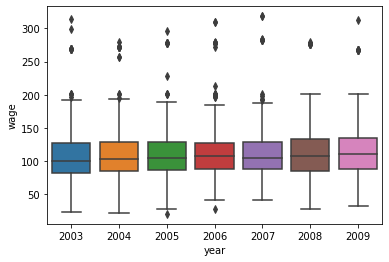

In [36]:
sns.boxplot(x = 'year',y = 'wage',data = wage)

In [37]:
# not much information with year

In [39]:
# fit a GAM where age has a degree 4 relationship with the model

X_transformed = dmatrix('cr(age, df=5, constraints = "center") + education + race + jobclass + health_ins', 
                       data = {'age':wage['age'],'education':wage['education'],'race':wage['race'],
                              'jobclass':wage['jobclass'],'health_ins':wage['health_ins']},return_type = 'dataframe')

model = sm.OLS(wage['wage'], X_transformed).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     102.5
Date:                Tue, 17 Nov 2020   Prob (F-statistic):          7.16e-242
Time:                        11:16:03   Log-Likelihood:                -14861.
No. Observations:                3000   AIC:                         2.975e+04
Df Residuals:                    2985   BIC:                         2.984e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [40]:
# 8. Fit some of the non-linear models investigated in this chapter to the Auto data set. Is there evidence 
# for non-linear relationships in this data set? Create some informative plots to justify your answer


auto = pd.read_csv('/home/abhishek/Desktop/ISLR-Applied-Exercises-in-Python/data/Auto.csv')
print(auto.shape)
auto.head()

(397, 9)


,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino
